In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy 
import random
import time 
import sys
import os
import tifffile
import io
import pickle
import matplotlib

from matplotlib import pyplot
from PIL import Image

from pysted import base, utils, raster, bleach_funcs

to_insert = "../.."
while to_insert in sys.path:
    sys.path.remove(to_insert)
sys.path.insert(0, to_insert)

from src.tools import datamap_generator
from src.create import create_microscope, create_dymin_microscope, create_rescue_microscope
from src.experiment import Experiment
from src.defaults import P_EX, P_STED, PDT

# FIRST EXP
# fluo = {
#     # All values are the ones used by Albert except phyreact, determined through optim + manual fine tuning
#     "lambda_": 635e-9,
#     "qy": 0.6,  # COPIED FROM BEFORE
#     "sigma_abs": {
#         635: 0.1e-21,  # Table S3, Oracz et al., nature 2017
#         750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz et al., nature 2017
#     },
#     "sigma_ste": {
#         750: 4.8e-22,  # Table S3, Oracz et al., nature 2017
#     },
#     "sigma_tri": 10.14e-21,  # COPIED FROM BEFORE
#     "tau": 3.5e-9,  # @646nm, ATTO Fluorescent labels, ATTO-TEC GmbH catalog 2016/2018
#     "tau_vib": 1.0e-12,  # t_vib, Table S3, Oracz et al., nature 2017
#     "tau_tri": 1.2e-6,  # COPIED FROM BEFORE
#     "phy_react": {
#         635: 3.5801577460614683e-09,  # found through optim
#         750: 4.450819912845956e-09 / 100,  # og value found through optim + divided by 100 through fiddling
#     },
#     "k_isc": 0.48e+6,
#     "k0" : 0,
#     "k1" : 1.3e-15,
#     "b" : 1.4,
#     "triplet_dynamic_frac" : 0,    
# }

fluo = { # ATTO647N
    "lambda_": 690e-9, # Figure 1, Oracz2017
    "qy": 0.65,  # Product Information: ATTO 647N (ATTO-TEC GmbH)
    "sigma_abs": {
        635: 1.0e-20, #Table S3, Oracz2017
        750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz2017
    },
    "sigma_ste": {
        750: 4.8e-22, #Table S3, Oracz2017
    },
    "tau": 3.5e-9, #Table S3, Oracz2017
    "tau_vib": 1.0e-12, #t_vib, Table S3, Oracz2017 
    "tau_tri": 25e-6, # pasted from egfp
    "k0": 0, #Table S3, Oracz2017
    "k1": 1.3e-15, #Table S3,  (changed seemingly wrong unit: 5.2 × 10−10 / (100**2)**1.4)
#     "b":1.4, #Table S3, Oracz2017
    "b":1.40, #Table S3, Oracz2017    
    "triplet_dynamics_frac": 0, #Ignore the triplet dynamics by default
}

objective = {"transmission" : {488: 0.84, 535: 0.85, 550: 0.86, 585: 0.85, 575: 0.85, 635: 0.85, 690: 0.85, 750: 0.85}}
laser_ex = {"lambda_" : 635e-9}
laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.01, "anti_stokes" : True}
num_mol = 100

# # SECOND EXP
# fluo = {
#     # All values are the ones used by Albert except phyreact, determined through optim + manual fine tuning
#     "lambda_": 635e-9,
#     "qy": 0.6,  # COPIED FROM BEFORE
#     "sigma_abs": {
#         635: 0.1e-21,  # Table S3, Oracz et al., nature 2017
#         750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz et al., nature 2017
#     },
#     "sigma_ste": {
#         750: 4.8e-22,  # Table S3, Oracz et al., nature 2017
#     },
#     "sigma_tri": 10.14e-21,  # COPIED FROM BEFORE
#     "tau": 3.5e-9,  # @646nm, ATTO Fluorescent labels, ATTO-TEC GmbH catalog 2016/2018
#     "tau_vib": 1.0e-12,  # t_vib, Table S3, Oracz et al., nature 2017
#     "tau_tri": 1.2e-6,  # COPIED FROM BEFORE
#     "phy_react": {
#         635: 2.98094869e-09,  # found through optim
#         750: 9.15758276e-08 / 1000,  # og value found through optim + divided by 100 through fiddling
#     },
#     "k_isc": 0.48e+6  # COPIED FROM BEFORE
# }
# laser_ex = {"lambda_" : 635e-9}
# laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.01}
# num_mol = 450

# # OTHER EXP
# fluo = {
#     # All values are the ones used by Albert except phyreact, determined through optim + manual fine tuning
#     "lambda_": 635e-9,
#     "qy": 0.6,  # COPIED FROM BEFORE
#     "sigma_abs": {
#         635: 0.1e-21,  # Table S3, Oracz et al., nature 2017
#         750: 3.5e-25,  # (1 photon exc abs) Table S3, Oracz et al., nature 2017
#     },
#     "sigma_ste": {
#         750: 4.8e-22,  # Table S3, Oracz et al., nature 2017
#     },
#     "sigma_tri": 10.14e-21,  # COPIED FROM BEFORE
#     "tau": 3.5e-9,  # @646nm, ATTO Fluorescent labels, ATTO-TEC GmbH catalog 2016/2018
#     "tau_vib": 1.0e-12,  # t_vib, Table S3, Oracz et al., nature 2017
#     "tau_tri": 1.2e-6,  # COPIED FROM BEFORE
#     "phy_react": {
#         635: 3.053e-05,  # found through optim
#         750: 4.26e-09,  # og value found through optim + divided by 100 through fiddling
#     },
#     "k_isc": 0.48e+6  # COPIED FROM BEFORE
# }
# laser_ex = {"lambda_" : 635e-9}
# laser_sted = {"lambda_" : 750e-9, "zero_residual" : 0.01}
# num_mol = 23

No module named 'specpy'
Calling these functions might raise an error.

Falling back to the debug files...
Could not load microscope interface. Some functions may not be available.


In [11]:
def savefig(fig, ax, savepath, extension="pdf", save_white=False, **kwargs):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        dirname = os.path.dirname(savepath)
        basename = os.path.basename(savepath)
        
        # Creates empty directory
        os.makedirs(os.path.join(dirname, "white"), exist_ok=True)
        savepath = os.path.join(dirname, "white", basename)

        buf = io.BytesIO()
        pickle.dump(fig, buf)
        buf.seek(0)
        fig = pickle.load(buf)
        
        change_figax_color(fig, ax, **kwargs)
        fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True, dpi=600)
        
        pyplot.close(fig)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            new_colors = [mimic_white_alpha(c) for c in new_colors]
            collection.set_facecolors(new_colors)
            collection.set_alpha(1)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()] 
            new_colors = [mimic_white_alpha(c) for c in new_colors]            
            collection.set_edgecolors(new_colors)
            collection.set_alpha(1)            

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
        
def mimic_white_alpha(color):
    """
    Mimics the color that would be perceived of a color on a white 
    background
    
    :param color: A `matplotlib.collections` of lines
    
    :returns : A `list` of the colors
    """
    c_rgba = matplotlib.colors.to_rgba(color)
    c_rgb, alpha = c_rgba[:3], c_rgba[-1]
    return matplotlib.colors.to_hex(tuple(c * alpha + (1 - alpha) for c in c_rgb))    

In [12]:
P_STED = 15e-3
P_EX = 2.0e-6
PDT = 10e-6

NUM_ACQ = 20
all_histories = []
for i in range(1):
    molecules_disposition, positions = datamap_generator(
        shape = (192, 192),
        sources = 100,
        molecules = num_mol,
        shape_sources = (2, 2),
        random_state = 42 + i
    )

    experiment = Experiment()

    # Creates the STED microscope
    sted_microscope, datamap, sted_params = create_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : P_EX, "p_sted" : P_STED, "pdt" : PDT}
    )
    i_ex, _, _ = sted_microscope.cache(datamap.pixelsize, save_cache=False)
    laser_row, laser_col = i_ex.shape
    datamap.set_roi(i_ex, {"rows" : [32, 32 + 128 - 1], # necessary for now
                           "cols" : [32, 32 + 128 - 1]})
    experiment.add("STED", sted_microscope, datamap, sted_params)
    
    # Creates the RESCue microscope
    rescue_microscope, datamap, rescue_params = create_rescue_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        microscope = {
            "lower_threshold" : [0, -1],#[3, -1],
            "upper_threshold" : [100, -1],#[6, -1],
#             "decision_time" : [25e-6, -1]
            "decision_time" : [0.25 * PDT, -1]
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : P_EX, "p_sted" : P_STED, "pdt" : PDT}
    )
    i_ex, _, _ = rescue_microscope.cache(datamap.pixelsize, save_cache=False) 
    laser_row, laser_col = i_ex.shape
    datamap.set_roi(i_ex, {"rows" : [32, 32 + 128 - 1], 
                           "cols" : [32, 32 + 128 - 1]})
    experiment.add("RESCue", rescue_microscope, datamap, rescue_params)    

    # Creates the DyMIN microscope
    dymin_microscope, datamap, dymin_params = create_dymin_microscope(
        datamap = {
            "whole_datamap" : molecules_disposition,
            "datamap_pixelsize" : 20e-9
        },
        microscope = {
            "scale_power" : [0., 0.25, 1.],
#             "decision_time" : [10e-6, 10e-6, -1],
            "decision_time" : [0.2 * PDT, 0.2 * PDT, -1],            
            "threshold_count" : [12, 10, 0]
        },
        fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
        imaging = {"p_ex" : P_EX, "p_sted" : P_STED, "pdt" : PDT}        
    )
    i_ex, _, _ = dymin_microscope.cache(datamap.pixelsize, save_cache=False)
    laser_row, laser_col = i_ex.shape
    datamap.set_roi(i_ex, {"rows" : [32, 32 + 128 - 1], 
                           "cols" : [32, 32 + 128 - 1]})
    experiment.add("DyMIN", dymin_microscope, datamap, dymin_params)

    histories = experiment.acquire_all(NUM_ACQ, bleach=True, processes=3, verbose=False)
    
    all_histories.append(histories)

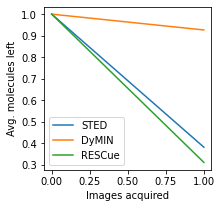

In [5]:
%matplotlib inline
def get_molecules_left(history):
    molecules = history["datamap"][:, history["datamap"][0] > 0]
    molecules = molecules.mean(axis=-1) / molecules.mean(axis=-1)[0]    
    return molecules

# Bleaching curve
fig, ax = pyplot.subplots(figsize=(3,3))
for microscope_name in ["STED", "DyMIN", "RESCue"]:
    
    molecules = [get_molecules_left(histories[microscope_name]) for histories in all_histories]
    mean, std = numpy.mean(molecules, axis=0), numpy.std(molecules, axis=0)
    
    x = numpy.arange(len(mean))
    ax.plot(x, mean, label=microscope_name)
    ax.fill_between(x, mean - std, mean + std, alpha=0.3)    

ax.set(
    xlabel="Images acquired", ylabel="Avg. molecules left"
)
ax.legend()
# fig.savefig("./panels/bleach_curve.pdf", transparent=True, bbox_inches="tight")
# savefig(fig, ax, "./panels/bleach_curve", save_white=True)
pyplot.show()

In [6]:
%matplotlib notebook
def show_montage(images, nrows=1, ncols=10):
    """
    Creates a 2d montage from the scores
    """    
    h, w = (128, 128)
    collage = Image.new("I;16", (ncols * w, nrows * h))
    for j in range(nrows):
        for i in range(ncols):

            image = images[j][i]

            pil_img = Image.fromarray(image, "I;16")
            # Resizes the image
            pil_img = pil_img.resize(size=(w, h), resample=Image.Resampling.NEAREST)
            collage.paste(pil_img, (i * w, j * h))
    return collage
            
image_ids = numpy.clip(numpy.arange(0, NUM_ACQ + 5, 5) - 1, 0, NUM_ACQ)
# image_ids = [0, 1]
for microscope_name in ["STED", "DyMIN", "RESCue"]:
    
    history = all_histories[0][microscope_name]

    acquisitions = history["acquisition"][image_ids]
    acquisitions = acquisitions[numpy.newaxis, ...].astype(numpy.uint16)
    print(acquisitions.max())

    collage = show_montage(acquisitions, nrows=1, ncols=len(image_ids)) 
    collage = numpy.array(collage)
    fig,ax = pyplot.subplots(figsize=(10,3))
    ax.set_title(microscope_name)
    ax.imshow(collage)
    pyplot.show()
#     tifffile.imwrite(f"./panels/example-image_{microscope_name}.tif", collage.astype(numpy.uint16))

IndexError: index 2 is out of bounds for axis 0 with size 2

# Complete datamap acquisition

I will acquire an image on the first and last complete field of views from the datamap

<IPython.core.display.Javascript object>


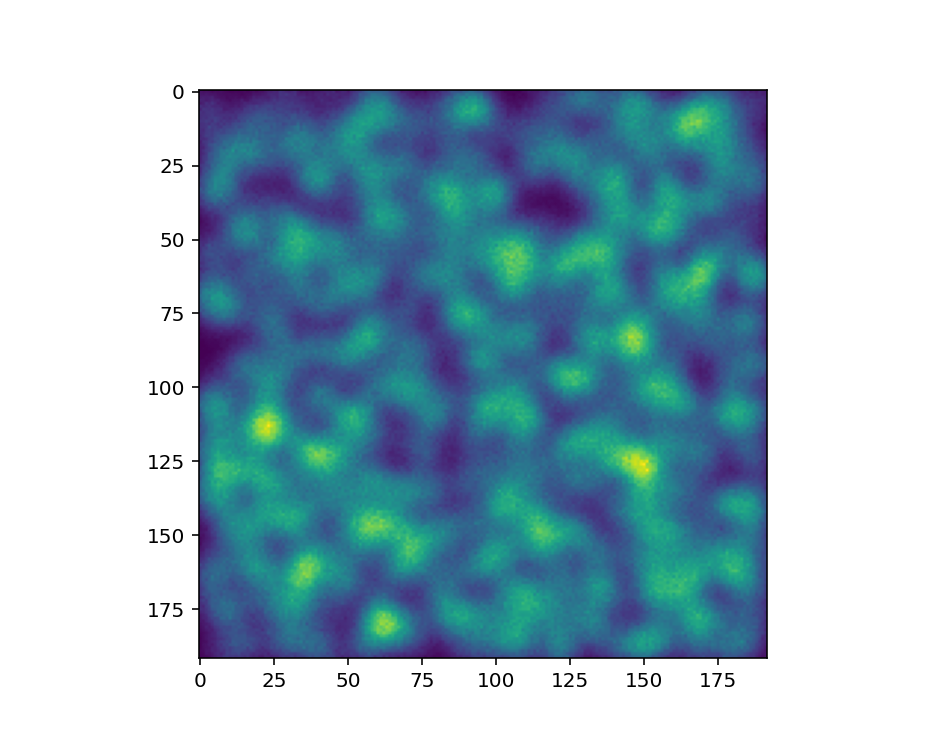

<IPython.core.display.Javascript object>


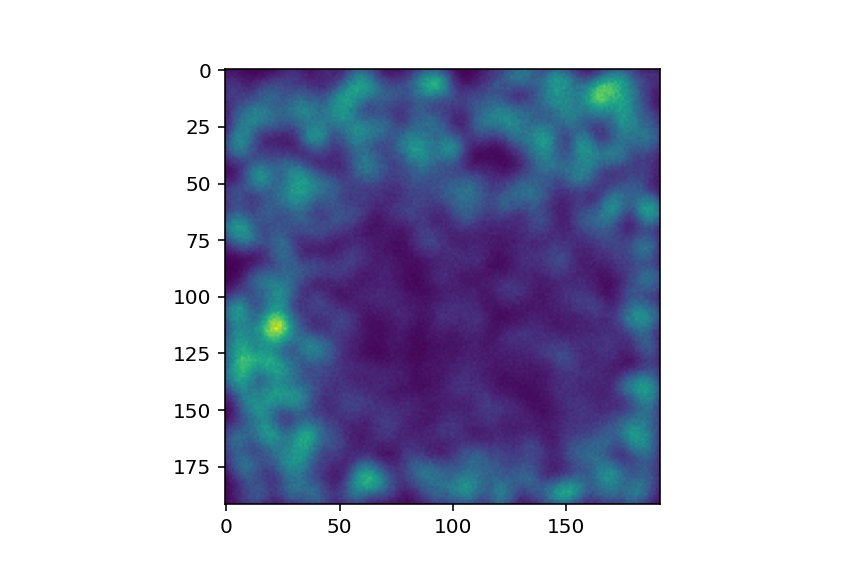

<IPython.core.display.Javascript object>


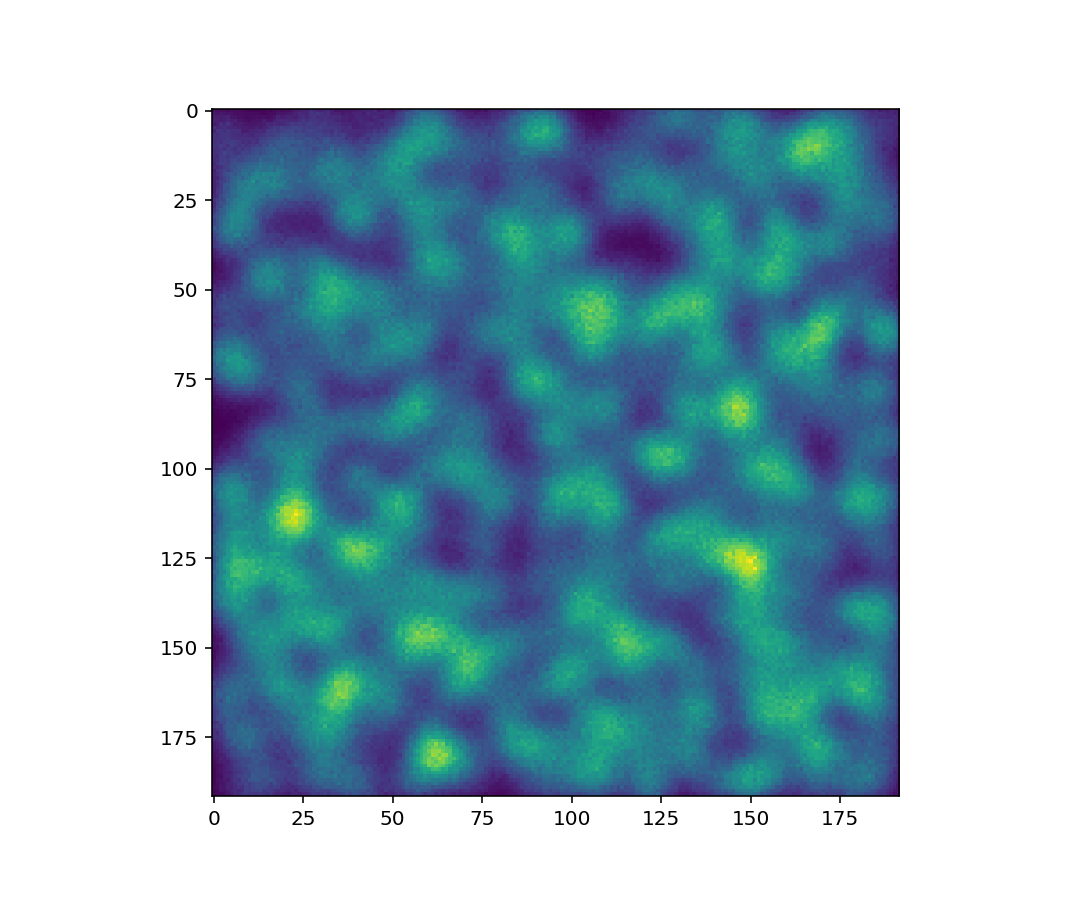

<IPython.core.display.Javascript object>


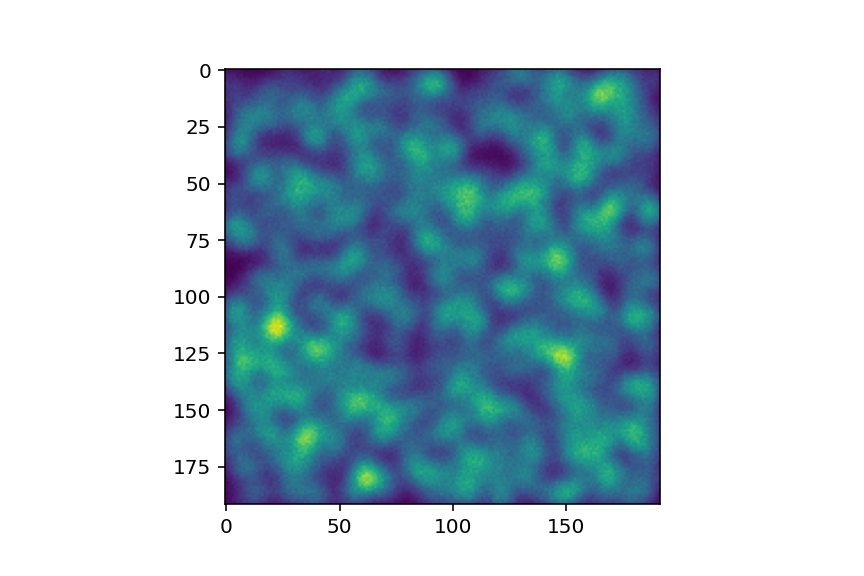

<IPython.core.display.Javascript object>


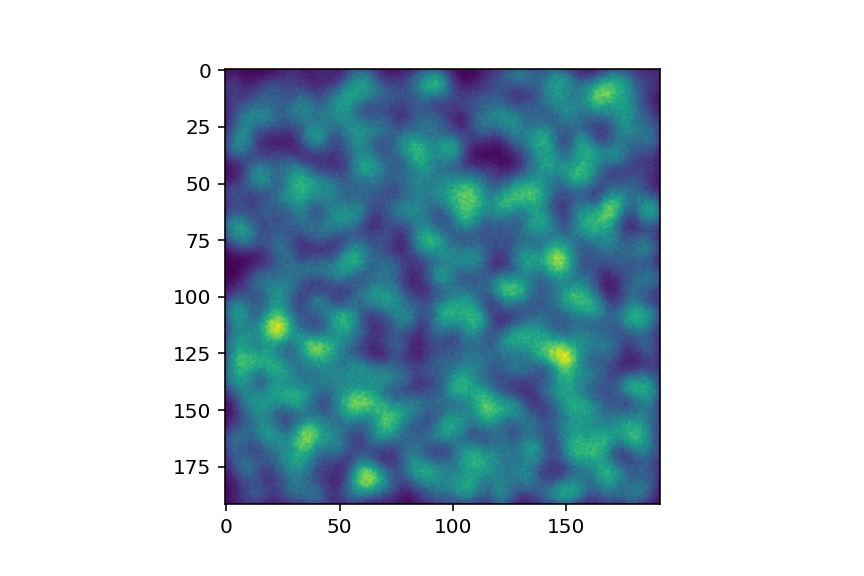

<IPython.core.display.Javascript object>


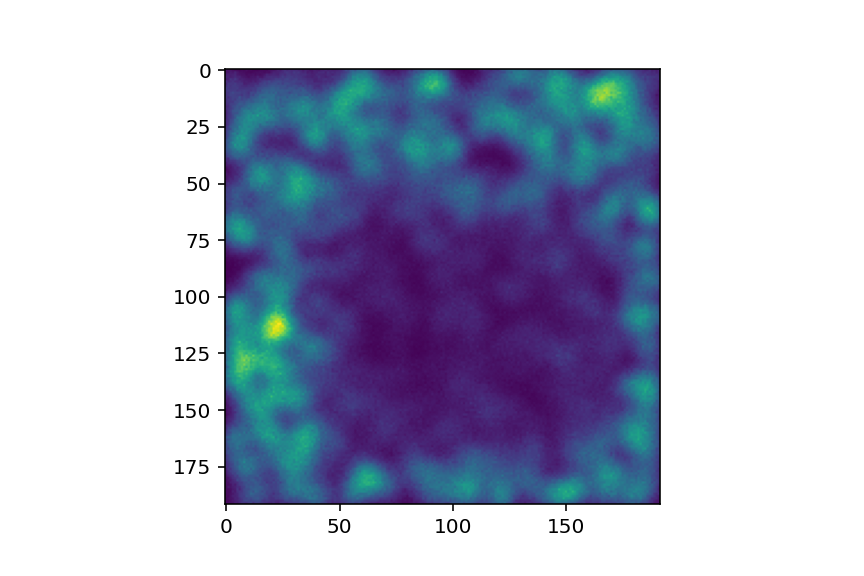

In [9]:
P_STED = 15e-3
P_EX = 2.0e-6
PDT = 10e-6

NUM_ACQ = 10

history = all_histories[0]
for microscope_name in ["STED", "DyMIN", "RESCue"]:
    for molecules_disposition in [history[microscope_name]["whole-datamap"][0], history[microscope_name]["whole-datamap"][-1]]:
    
        experiment = Experiment()

        # Creates the STED microscope
        microscope, datamap, sted_params = create_microscope(
            datamap = {
                "whole_datamap" : molecules_disposition,
                "datamap_pixelsize" : 20e-9
            },
            fluo=fluo, laser_ex=laser_ex, laser_sted=laser_sted, objective=objective,
            imaging = {"p_ex" : P_EX, "p_sted" : 0., "pdt" : PDT}
        )
        i_ex, _, _ = sted_microscope.cache(datamap.pixelsize, save_cache=False)
        laser_row, laser_col = i_ex.shape
        datamap.set_roi(i_ex, "max")
        experiment.add("Conf", microscope, datamap, sted_params)

        hist = experiment.acquire_all(1, bleach=False)
        
        fig, ax = pyplot.subplots()
        ax.imshow(hist["Conf"]["acquisition"][-1], cmap="hot", vmin=0, vmax=200)
        pyplot.show()